In [764]:
#over samp-undersamp -normal model oluştur ensemble baggin regressor

#holiday

#usd dolar

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import warnings
from tqdm import tqdm
import seaborn as sns
random_state =537

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 181)

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


from sklearn.metrics import f1_score

import datetime #roller binnig yap

In [765]:
drop = ["TransactionID","UserID","ProductID","flag"]
date = ["DateTime","UserFirstTransaction"]
sparse_cat = ["Channel","PaymentType","Discount","Gender"]
dense_cat = ["Location","Category"]
category = sparse_cat+dense_cat
target = "churn"

split1 = "2017-06-01 00:00:00"
split2 = "2018-02-28 00:00:00"


In [766]:
hol = pd.read_csv('/kaggle/input/turkish-calendar-1994-2024/Calendar.csv')
hol = hol[['CALENDAR_DATE','RAMADAN_FLAG','PUBLIC_HOLIDAY_FLAG']].rename(columns={'CALENDAR_DATE':'ds'})
hol['holiday'] = np.where((hol['RAMADAN_FLAG'] == 'Y') | (hol['PUBLIC_HOLIDAY_FLAG'] == 'Y'), 'TR-Holidays', 0)
hol = hol[['ds','holiday']]
hol = hol[hol['holiday'] == 'TR-Holidays'].reset_index(drop=True)

In [767]:
df1 = pd.read_csv("/kaggle/input/metu-comp/data1.csv")
df2 = pd.read_csv("/kaggle/input/metu-comp/data2.csv")
df3 = pd.read_csv("/kaggle/input/metu-comp/data3.csv")
df1 =df1.iloc[:,:5].dropna(axis=0)
df2=df2.dropna(axis=0)
df3=df3.dropna(axis=0)

In [768]:
for i in df1.columns:
    if(i != "UserID"):
        df3[i] = df3.UserID.map(dict(zip(df1.UserID,df1[i])))
df3["Category"] = df3.ProductID.map(dict(zip(df2.ProductID,df2.Category)))
df = df3.copy()

In [769]:
df.DateTime = pd.to_datetime(df.DateTime)
df.dropna(axis=0,inplace=True)

# External Data - Kullanılmadı (holliday,usd) denendi

In [770]:
# def holl(x):
#     if x in hol.ds.values:
#         return 1
#     else:
#         return 0
    
    
# tqdm.pandas()
df["ds"] = df.DateTime.astype(str).apply(lambda x:x[:10])

# df["hols"] = df.ds.progress_apply(holl)

# Split twice 9Month -train-test

In [771]:
df_1 = df[df.DateTime < "2017-10-01 00:00:00"].copy()
df_2 = df[df.DateTime >= "2017-10-01 00:00:00"].copy()

# Split active-passive

In [772]:
def prep_data(x,date= split1):
    df = x.copy()
    df["flag"] = ""
    df.loc[df.DateTime < date,"flag"] = "before"
    df.loc[df.DateTime > date,"flag"] = "after"
    print("Active:",df[df.flag == "before"].shape[0],"Passive:",df[df.flag == "after"].shape[0],"Default:",df.shape)
    after = pd.DataFrame(set(df[df.flag == "after"].UserID),columns=["UserID"])
    if(df[df.flag == "before"].shape[0]+df[df.flag == "after"].shape[0]==df.shape[0]):
        assert("Bölerken boşluk oluştu")
    after["churn"] = 1
    df["churn"] = df.UserID.map(dict(zip(after.UserID,after.churn)))
    df["churn"] = df["churn"].astype(object)
    df.churn.fillna(value=0,inplace=True)
    return df

In [773]:
def create_time_featue(x,i,first=False):
    df = x.copy()
    if(first):
        df[i] = df[i].dt.year
    else:
        df[f'hour_{i}'] = df[i].dt.hour
        df[f'dayofweek_{i}'] = df[i].dt.dayofweek
        df[f'quarter_{i}'] = df[i].dt.quarter
        df[f'month_{i}'] = df[i].dt.month
        df[f'year_{i}'] = df[i].dt.year
        df[f'dayofyear_{i}'] = df[i].dt.dayofyear
        df[f'dayofmonth_{i}'] = df[i].dt.day
    return df

In [774]:
def cat_parse_to_dense(x):
    cat_dense = {
     "Female Fashion":"Fashion",
     "TVs and TV Sets":"Electronic",
     "Sport Shoes":"Fashion",
     "Smart Phones":"Electronic", 
     "Female Shoes":"Fashion",
     "Computers & Laptops":"Electronic",
     "Male Shoes":"Fashion",
     "Kitchen Electronics":"Electronic",
     "Male Fashion":"Fashion",
     "Sound Systems":"Electronic",
     "Hobbies":"Hobbies",
     "Outdoor Sports":"Hobbies",
     "Smart Watches":"Electronic",
     "Indoor Sports":"Hobbies"
    }
    df =x.copy()
    df["dense_category"] =df.Category.replace(cat_dense)
    dense_cat.append("dense_category")
    category.append("dense_category")
    return df

In [775]:
def dense_enc(x,cols):
    df =x.copy()
    le = LabelEncoder()
    for i in cols:
        df[i] = le.fit_transform(df[i])
    return df

def sparse_enc(x,cols):
    df =x.copy()
    df = pd.get_dummies(df,columns=cols)
    return df


In [776]:
def drop_col(x,cols):
    df = x.copy()
    return df.drop(cols,axis=1)

In [777]:
def feature_enginar(x):
    df = x.copy()
    df["since_your_first_purchase"] = df["year_DateTime"]-df["UserFirstTransaction"]
    df["sum_price"] = df.groupby("UserID").Price.cumsum()
    df["count_User"] = df.groupby("UserID").Price.cumcount()
#     df["mounthly_sale"] = df.groupby("month_DateTime").Price.cumsum()
#     df["mounthly_sale"] = df.groupby("month_DateTime").Price.cumcount()
    
    return df

In [778]:
#before after ayrımı
def over_samp(x,amount = 0,divide=1):
    amount = x.churn.value_counts()[1]
    df = x.copy()
    df1 = x.copy()
    df = df[df.churn == 1].sample(int(amount/divide),replace=True)
    df = pd.concat([df1[df1.churn==0],df])
    print(df.churn.value_counts())
    return df

def smote_samp(df):
    df1 =df.copy()
    oversample = SMOTE()
    df1, y = oversample.fit_resample(df1.drop(["churn"],axis=1), df1.churn)
    df1["churn"] = y
    print(df1.churn.value_counts())
    return df1


def under_samp(df):
    df = df.copy()
    rus = RandomUnderSampler(random_state=0)
    x,y = rus.fit_resample(df.drop(["churn"],axis=1), df.churn)
    x["churn"] = y
    print(x.churn.value_counts())
    return x

# Data prep

In [779]:
df_1 = prep_data(df_1)

df_1.DateTime = pd.to_datetime(df_1.DateTime)
df_1 = create_time_featue(df_1,"DateTime")

df_1.UserFirstTransaction = pd.to_datetime(df_1.UserFirstTransaction)
df_1 = create_time_featue(df_1,"UserFirstTransaction",first=True)

df_1 = feature_enginar(df_1)
df_1 = df_1[df_1.flag == "before"]    
df_1 = drop_col(df_1,drop+["DateTime","ds"])
df_1 = cat_parse_to_dense(df_1)
df_1 = dense_enc(df_1,dense_cat)
df_1 = sparse_enc(df_1,sparse_cat)



df_1_over = over_samp(df_1,divide=3/2)
df_1_smote = smote_samp(df_1)
df_1_under = under_samp(df_1)


Active: 15045 Passive: 14501 Default: (29546, 15)
1.0    9008
0.0    1532
Name: churn, dtype: int64
1.0    13513
0.0    13513
Name: churn, dtype: int64
0.0    1532
1.0    1532
Name: churn, dtype: int64


In [780]:
# df_1["ds"]=df_1.DateTime.astype(str).apply(lambda x:x[:10])
# df_1.ds.map(dict(zip(hol.ds,hol.holiday)))
# df_1.hol.value_counts()

<AxesSubplot:>

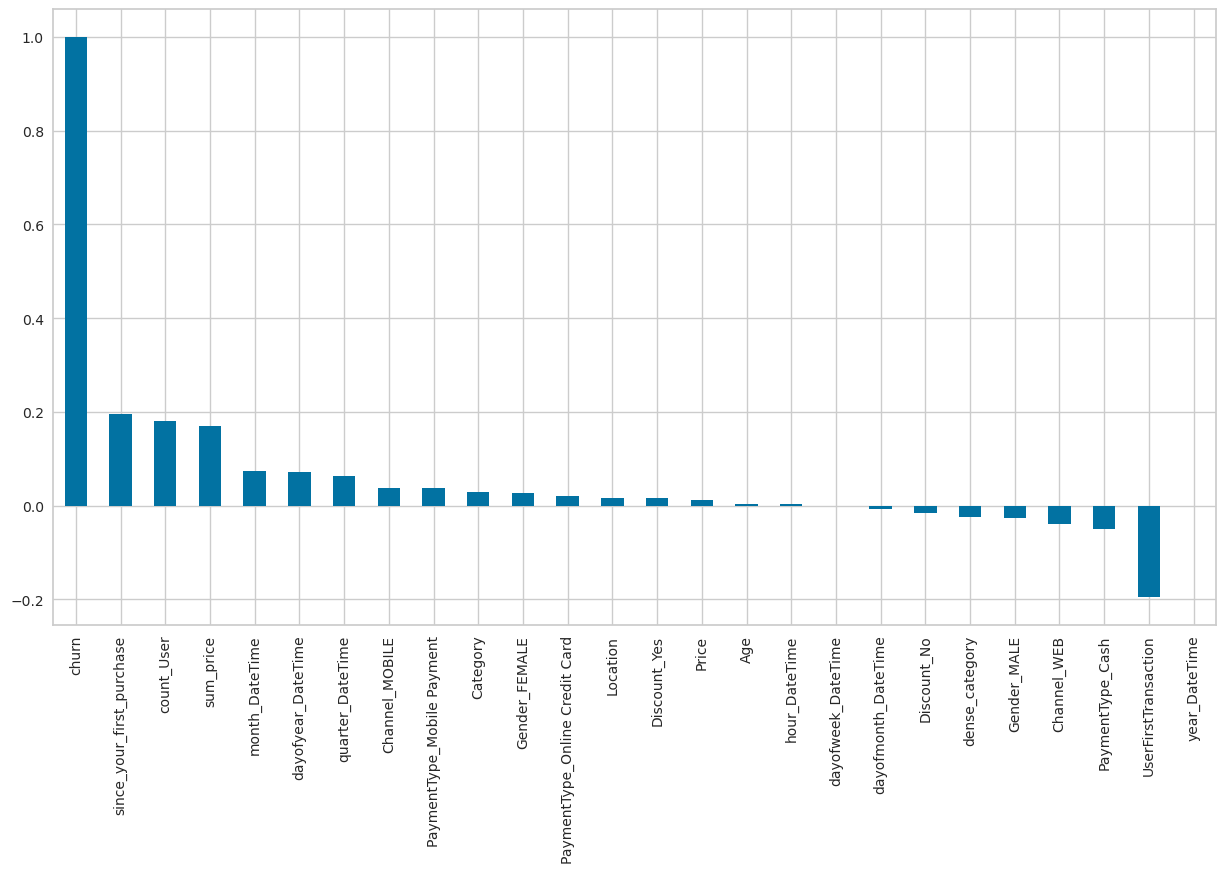

In [781]:
plt.figure(figsize=(15,8))
df_1.corr()['churn'].sort_values(ascending = False).plot(kind='bar')

In [782]:
df_2 = prep_data(df_2,split2)
df_s = df_2.copy()

df_2.DateTime = pd.to_datetime(df_2.DateTime)
df_2 = create_time_featue(df_2,"DateTime")

df_2.UserFirstTransaction = pd.to_datetime(df_2.UserFirstTransaction)
df_2 = create_time_featue(df_2,"UserFirstTransaction",first=True)

df_2 = feature_enginar(df_2)
df_2 = df_2[df_2.flag == "before"]    
df_2 = drop_col(df_2,drop+["DateTime","ds"])
df_2 = cat_parse_to_dense(df_2)
df_2 = dense_enc(df_2,dense_cat)
df_2 = sparse_enc(df_2,sparse_cat)



Active: 19121 Passive: 20392 Default: (39513, 15)


# Models


# Compare models

In [783]:
# # !pip install pycaret
# # df_1.churn = df_1.churn.astype(int)
# from pycaret.classification import ClassificationExperiment
# s = ClassificationExperiment()
# s.setup(data=df_1, target='churn')
# best =  s.compare_models()

# Regression

In [784]:

# def model_learn(x,y,x_test,y_test,model_name ="LR"):#bu biraz fazla scale ? 
#     x=x.copy()
#     y=y.copy()
#     scaler = MinMaxScaler()
#     x = pd.DataFrame(scaler.fit_transform(x.select_dtypes(np.number)),columns=x.select_dtypes(np.number).columns)
    
#     x_test = pd.DataFrame(scaler.fit_transform(x_test.select_dtypes(np.number)),columns=x_test.select_dtypes(np.number).columns)
#     model= ""
#     if(model_name == "LR"):
#         model = LogisticRegression()
#     elif(model_name == "XGB"):
#         model = xgb.XGBRegressor()
#     elif(model_name == "RF"):
#         model = RandomForestClassifier()
        
#     model.fit(x, y)
    
#     y_pred = model.predict(x_test)
    
#     y_pred = np.where(y_pred>0.5,1,0)
#     print("f1_score:",f1_score(y_test,y_pred))   
#     print("Report:\n",classification_report(y_test, y_pred))
#     print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))
    
#     if(model_name == "XGB"):
#         fi = pd.DataFrame(data=model.feature_importances_,
#                  index=model.feature_names_in_,
#                  columns=['importance'])
#         fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
#         plt.show()
    
#     return y_test,y_pred
# tu,yu = model_learn(x=df_1_under.drop(["churn"],axis=1),y=df_1_under.churn,x_test=df_2.drop(["churn"],axis=1),y_test=df_2.churn,model_name="XGB")
# to,yo = model_learn(x=df_1_over.drop(["churn"],axis=1),y=df_1_over.churn,x_test=df_2.drop(["churn"],axis=1),y_test=df_2.churn,model_name="XGB")
# ts,ys = model_learn(x=df_1_smote.drop(["churn"],axis=1),y=df_1_smote.churn,x_test=df_2.drop(["churn"],axis=1),y_test=df_2.churn,model_name="XGB")
# t,y = model_learn(x=df_1.drop(["churn"],axis=1),y=df_1.churn,x_test=df_2.drop(["churn"],axis=1),y_test=df_2.churn,model_name="XGB")
# tc,yc = model_learn(x=df_1_custom.drop(["churn"],axis=1),y=df_1_custom.churn,x_test=df_2.drop(["churn"],axis=1),y_test=df_2.churn,model_name="XGB")

# Regression_Bagging

In [785]:
# y_pred = yu*0.30+yo*0.2+ys*0.2+yc*0.30
# y_pred = np.where(y_pred>0.5,1,0)


# print("f1_score:",f1_score(t,y_pred))   
# print("Report:\n",classification_report(t, y_pred))
# # print("Confusion Matrix:\n",confusion_matrix(t, y_pred))

# cm = confusion_matrix(t, y_pred)
# ConfusionMatrixDisplay(confusion_matrix=cm  ).plot()
# plt.show()

# Classification 

In [786]:
def model_learn(x,y,x_test,y_test,model_name ="LR"):#bu biraz fazla scale ? 
    x=x.copy()
    y=y.copy()
    scaler = MinMaxScaler()
    x = pd.DataFrame(scaler.fit_transform(x.select_dtypes(np.number)),columns=x.select_dtypes(np.number).columns)
    
    x_test = pd.DataFrame(scaler.fit_transform(x_test.select_dtypes(np.number)),columns=x_test.select_dtypes(np.number).columns)
    model= ""
    if(model_name == "LR"):
        model = LogisticRegression(solver='newton-cg', class_weight='balanced')
    elif(model_name == "XGB"):
        from sklearn.utils import class_weight
        classes_weights = class_weight.compute_sample_weight(
            class_weight='balanced',
            y=y
        )
        model = xgb.XGBClassifier(sample_weight=classes_weights,base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              monotone_constraints='()', n_estimators=100,
              n_jobs=-1, num_parallel_tree=1, objective='binary:logistic',
              predictor='auto', random_state=7645, reg_alpha=0,)
    elif(model_name == "RF"):
        model = RandomForestClassifier()
    elif(model_name == "ETC"):
        model = ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight="classes_weights",
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_samples_leaf=1,
                     min_samples_split=2, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=-1, oob_score=False,
                     random_state=4317, verbose=0, warm_start=False,)
    elif(model_name == "CAT"):
        model = CatBoostClassifier(verbose=0)
#         y_pred2=s.predict_model(best, data=x_test)
    model.fit(x, y)
    
    y_pred = model.predict(x_test)
    
    print("f1_score:",f1_score(y_test,y_pred))   
    print("Report:\n",classification_report(y_test, y_pred))
    print("Confusion Matrix:\n",confusion_matrix(y_test, y_pred))
    print("*"*50)
    return y_test,y_pred
t,y = model_learn(x=df_1.drop(["churn"],axis=1),y=df_1.churn,x_test=df_2.drop(["churn"],axis=1),y_test=df_2.churn,model_name="CAT")
ts,ys = model_learn(x=df_1_smote.drop(["churn"],axis=1),y=df_1_smote.churn,x_test=df_2.drop(["churn"],axis=1),y_test=df_2.churn,model_name="CAT")
tu,yu = model_learn(x=df_1_under.drop(["churn"],axis=1),y=df_1_under.churn,x_test=df_2.drop(["churn"],axis=1),y_test=df_2.churn,model_name="CAT")
to,yo = model_learn(x=df_1_over.drop(["churn"],axis=1),y=df_1_over.churn,x_test=df_2.drop(["churn"],axis=1),y_test=df_2.churn,model_name="CAT")


f1_score: 0.9535974398587508
Report:
               precision    recall  f1-score   support

         0.0       0.32      0.10      0.16      1513
         1.0       0.93      0.98      0.95     17608

    accuracy                           0.91     19121
   macro avg       0.63      0.54      0.56     19121
weighted avg       0.88      0.91      0.89     19121

Confusion Matrix:
 [[  156  1357]
 [  325 17283]]
**************************************************
f1_score: 0.854633234698645
Report:
               precision    recall  f1-score   support

         0.0       0.16      0.49      0.24      1513
         1.0       0.95      0.78      0.85     17608

    accuracy                           0.76     19121
   macro avg       0.55      0.63      0.55     19121
weighted avg       0.88      0.76      0.81     19121

Confusion Matrix:
 [[  735   778]
 [ 3889 13719]]
**************************************************
f1_score: 0.8548676465959523
Report:
               precision    reca

# Classification bagging

In [787]:
y_pred = ys*0.5+yu*0.5
y_pred = np.where(y_pred>=0.5,1,0)
print("f1_score:",f1_score(t,y_pred))   
print("Report:\n",classification_report(t, y_pred))
print("Confusion Matrix:\n",confusion_matrix(t, y_pred))

f1_score: 0.8940105959471998
Report:
               precision    recall  f1-score   support

         0.0       0.19      0.43      0.27      1513
         1.0       0.95      0.85      0.89     17608

    accuracy                           0.81     19121
   macro avg       0.57      0.64      0.58     19121
weighted avg       0.89      0.81      0.84     19121

Confusion Matrix:
 [[  646   867]
 [ 2674 14934]]


In [788]:
ypred_final = yu
df_s = df_s[df_s.flag == "before"]
df_s["churn_pred"] = ypred_final
df_s.loc[:,["UserID","churn_pred"]].to_csv(f"submission_final.csv",index=False)

In [789]:
df_s.loc[:,["UserID","churn_pred"]].churn_pred.value_counts()

1.0    14163
0.0     4958
Name: churn_pred, dtype: int64

In [790]:
#balance problem
#outilar
#roll,mean,count,sum
#scaling ? 
#skew,log transform
# featureiner enginar ?
# overfitt
# other models
# hyperparamter
#cross val
# split is valid ?
